In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score
import numpy as np
from tqdm.notebook import tqdm, trange
torch.manual_seed(1)
pd_ori=pd.read_csv('all.csv')
from sklearn.model_selection import StratifiedShuffleSplit
sss= StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(pd_ori, pd_ori['label']):
    train_df=pd_ori.iloc[train_index]
    test_df=pd_ori.iloc[test_index]
train_df['label'].value_counts()/len(train_df)
from sklearn.model_selection import StratifiedShuffleSplit
sss= StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(test_df, test_df['label']):
    train_df=test_df.iloc[train_index]
    test_df=test_df.iloc[test_index]
train_df['label'].value_counts()/len(train_df)
vectorizer = CountVectorizer()


In [2]:
len(train_df)

97376

In [3]:
X_train = vectorizer.fit_transform(train_df.review).todense()
X_test  = vectorizer.transform(test_df.review).todense()

y_train = list([int(y) for y in train_df['label']])
y_test  = list([int(y) for y in test_df['label']])

In [4]:
def to_tensors(instance, label):
    '''Given some vectorized text and the integer label for its class, returns a tuple of these in Tensor format'''
    instance = torch.Tensor(instance)
    label = torch.LongTensor([int(label)])
    return (instance, label)



In [5]:
training_data = [to_tensors(row, y_train[i]) for i, row in enumerate(X_train)]
test_data = [to_tensors(row, y_test[i]) for i, row in enumerate(X_test)]

In [6]:
class LogisticRegression(nn.Module):
    def __init__(self, vocab_size, num_classes=2):
        super(LogisticRegression, self).__init__()
        self.betas = nn.Linear(vocab_size, num_classes)
    
    def forward(self, feature_vector):
        return self.betas(feature_vector)

In [7]:
loss_function = nn.CrossEntropyLoss()

vocab_size = len(vectorizer.vocabulary_)

model = LogisticRegression(vocab_size)

learning_rate = 5e-5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

for epoch in trange(10, desc='Epoch'):
    

    for (instance, label) in tqdm(training_data, leave=False, desc='Training Loop for Epoch %d' % epoch):
        model.zero_grad()        
        output = model(instance)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()

In [8]:

test_preds = []


with torch.no_grad():
    
    for (instance, label) in test_data:
        
        outputs = model(instance)
        
        test_preds.append(np.argmax(outputs))
            

In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
print(roc_auc_score(test_preds, y_test))

0.6542219270556198


In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pylab as plt

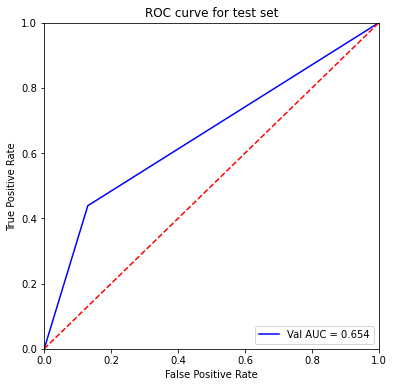

In [13]:
fpr, tpr, threshold = metrics.roc_curve(test_preds, y_test)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('ROC curve for test set')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
